In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#importing the database
data = pd.read_csv('/content/mnist_test-2.csv')


In [3]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.shape

(10000, 785)

In [5]:
Y_raw = data['label']
X_raw = data.drop(columns='label')

In [6]:
Y_raw.shape

(10000,)

In [7]:
X_raw.shape

(10000, 784)

In [10]:
X = X_raw.T / 255.0

# One-hot encode labels to shape (10, m)
def one_hot_encode(y, num_classes=10):
    m = y.shape[0]
    one_hot = np.zeros((num_classes, m))
    one_hot[y, np.arange(m)] = 1
    return one_hot

Y = one_hot_encode(Y_raw)

In [14]:
#shuffling the database
n = X.shape[1]
indices = np.random.permutation(n)

X_shuffled = X[:, indices]
Y_shuffled = Y[:, indices]

In [15]:
#Splitting the dataset into testing and training dataset
split_index = int(0.8 * n)

# Training set
X_train = X_shuffled[:, :split_index]   # shape: (784, 8000)
Y_train = Y_shuffled[:, :split_index]   # shape: (10, 8000)

# Test set
X_test = X_shuffled[:, split_index:]    # shape: (784, 2000)
Y_test = Y_shuffled[:, split_index:]    # shape: (10, 2000)

In [16]:
def initialize_parameters():
    np.random.seed(0)

    parameters = {
        "W1": np.random.randn(32, 784) * 0.01,
        "b1": np.zeros((32, 1)),

        "W2": np.random.randn(32, 32) * 0.01,
        "b2": np.zeros((32, 1)),

        "W3": np.random.randn(10, 32) * 0.01,
        "b3": np.zeros((10, 1)),
    }

    return parameters

In [17]:
#defining the activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

In [18]:
def forward_propagation(X, parameters):
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)

    cache = {
        "Z1": Z1, "A1": A1,
        "Z2": Z2, "A2": A2,
        "Z3": Z3, "A3": A3
    }

    return A3, cache

In [19]:
def backward_propagation(X, Y, parameters, cache):
    m = X.shape[1]

    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]

    A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
    Z1, Z2 = cache["Z1"], cache["Z2"]

    # Layer 3 (Output layer)
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # Layer 2
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Layer 1
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {
        "dW3": dW3, "db3": db3,
        "dW2": dW2, "db2": db2,
        "dW1": dW1, "db1": db1
    }

    return grads

In [20]:
def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]

    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    parameters["W3"] -= learning_rate * grads["dW3"]
    parameters["b3"] -= learning_rate * grads["db3"]

    return parameters

In [24]:
def compute_loss(Y, A3):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A3 + 1e-8)) / m
    return loss

def train(X_train, Y_train, num_epochs, learning_rate, print_loss=True):
    parameters = initialize_parameters()
    losses = []

    for i in range(num_epochs):
        A3, cache = forward_propagation(X_train, parameters)
        loss = compute_loss(Y_train, A3)
        losses.append(loss)

        grads = backward_propagation(X_train, Y_train, parameters, cache)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_loss and i % 100 == 0:
            print(f"Epoch {i}: Loss = {loss:.4f}")

    return parameters, losses

In [30]:
parameters, losses = train(X_train, Y_train, num_epochs=3500, learning_rate=0.1)

Epoch 0: Loss = 2.3026
Epoch 100: Loss = 2.3009
Epoch 200: Loss = 2.3006
Epoch 300: Loss = 2.3002
Epoch 400: Loss = 2.2987
Epoch 500: Loss = 2.2688
Epoch 600: Loss = 1.7466
Epoch 700: Loss = 1.1248
Epoch 800: Loss = 0.7037
Epoch 900: Loss = 0.5870
Epoch 1000: Loss = 0.5468
Epoch 1100: Loss = 0.5155
Epoch 1200: Loss = 0.4547
Epoch 1300: Loss = 0.4072
Epoch 1400: Loss = 0.3646
Epoch 1500: Loss = 0.3176
Epoch 1600: Loss = 0.2784
Epoch 1700: Loss = 0.2467
Epoch 1800: Loss = 0.2214
Epoch 1900: Loss = 0.1986
Epoch 2000: Loss = 0.1789
Epoch 2100: Loss = 0.1617
Epoch 2200: Loss = 0.1460
Epoch 2300: Loss = 0.1321
Epoch 2400: Loss = 0.1198
Epoch 2500: Loss = 0.1089
Epoch 2600: Loss = 0.0991
Epoch 2700: Loss = 0.0904
Epoch 2800: Loss = 0.0825
Epoch 2900: Loss = 0.0754
Epoch 3000: Loss = 0.0690
Epoch 3100: Loss = 0.0631
Epoch 3200: Loss = 0.0577
Epoch 3300: Loss = 0.0528
Epoch 3400: Loss = 0.0483


In [31]:
def predict(X, parameters):
    A3, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A3, axis=0)
    return predictions



In [32]:
def compute_accuracy(X, Y_true, parameters):
    Y_pred = predict(X, parameters)
    Y_actual = np.argmax(Y_true, axis=0)
    accuracy = np.mean(Y_pred == Y_actual) * 100
    return accuracy

In [33]:
test_accuracy = compute_accuracy(X_test, Y_test, parameters)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 93.20%


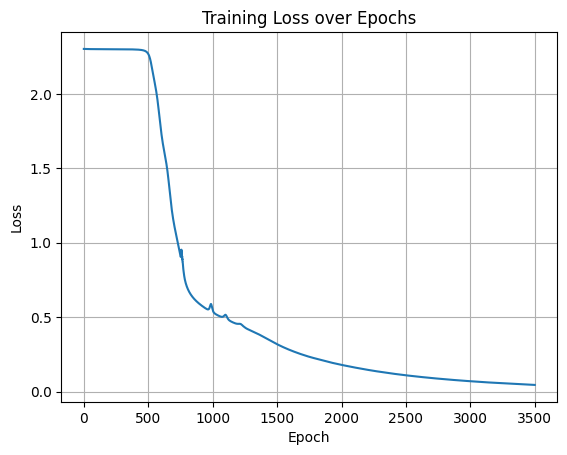

In [35]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()